# CNN Model for Violence detection in Videos

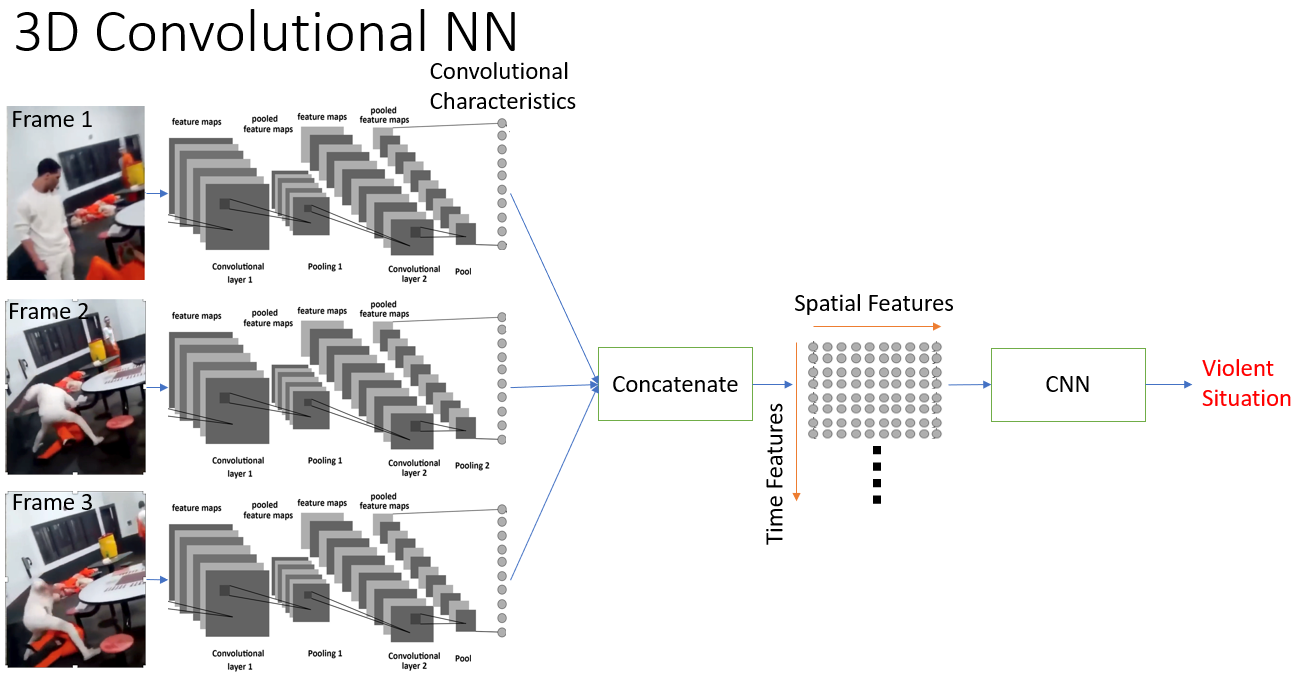

In [5]:
import numpy as np
import cv2 
import tensorflow as tf
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import os

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi

os.environ['KAGGLE_USERNAME'] = "xxxxxx"                 #Manually input from kaggle
os.environ['KAGGLE_KEY'] = "xxxxxx"   #Manually input from kaggle

api = KaggleApi()
api.authenticate()


api.dataset_download_files('mohamedmustafa/real-life-violence-situations-dataset', path="./Videos/", unzip=True)
del api

In [3]:
base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))

58889256/58889256 [==============================] - 25s 0us/step


In [4]:
model = Sequential([
    base_model,
    Flatten()
])

In [12]:
def read_Video(path: str):
    frames = []
    vid_Cap = cv2.VideoCapture(path)

    success, image = vid_Cap.read()

    while success:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        frames.append(cv2.resize(image, (224,224)))
        success, image = vid_Cap.read()

    return frames

In [26]:
def convFeatures(frames: np.array):
    conv_features = model.predict(np.array(frames), verbose = 0)
    return conv_features

In [28]:
def resize_zeros(img_features, maxFrames):
    rows, cols = img_features.shape
    zeroMx = np.zeros((maxFrames - rows, cols))
    return np.concatenate((img_features, zeroMx),axis = 0)

#### Training dataset *error induction
##### TF RECORDS

In [56]:
import glob
import random
from tqdm import tqdm

paths = ['Videos/Real Life Violence Dataset/NonViolence/', 'Videos/Real Life Violence Dataset/Violence/']
video_Paths = []


MAX_fRAMES = 190


for label,folder in enumerate(paths):
    for path in glob.glob(folder + '*.mp4'):
        if random.random() <= 0.6:
            video_Paths.append((label,path))
random.shuffle(video_Paths)

In [57]:
eval_files = [path for label,path in video_Paths[int(0.9*len(video_Paths)) +1:: ]]
test_files = [path for label,path in video_Paths[int(0.8*len(video_Paths)) +1:int(0.9*len(video_Paths)) +1 ]]

In [59]:
def createTF_Example(img_feature, label):
    sample = {
        'height' : tf.train.Feature( int64_list = tf.train.Int64List(value = [img_feature.shape[0]])),
        'width': tf.train.Feature( int64_list = tf.train.Int64List(value = [img_feature.shape[1]])),
        'img': tf.train.Feature( bytes_list = tf.train.BytesList(value = [img_feature.tobytes()])),
        'label': tf.train.Feature( int64_list = tf.train.Int64List(value = [label]))
    }
    return tf.train.Example(features = tf.train.Features(feature = sample))

In [63]:
train_writer = tf.io.TFRecordWriter('train.record')
test_writer = tf.io.TFRecordWriter('test.record')
eval_writer = tf.io.TFRecordWriter('eval.record')

for label, path in tqdm(video_Paths):
    frames = read_Video(path)

    if len(frames) < MAX_fRAMES:
        imgFeature = convFeatures(frames=frames)
        imgFeature = resize_zeros(imgFeature, MAX_fRAMES)

        example = createTF_Example(imgFeature, label)
  
        if path in eval_files:
            eval_writer.write(example.SerializeToString())
        elif path in test_files:
            test_writer.write(example.SerializeToString())
        else:
            train_writer.write(example.SerializeToString())
            
eval_writer.close()
test_writer.close()
train_writer.close()

100%|██████████| 599/599 [14:23<00:00,  1.44s/it]


#### Read TF-Records

In [64]:
train_dataset = tf.data.TFRecordDataset('train.record')
test_dataset = tf.data.TFRecordDataset('test.record')
eval_dataset = tf.data.TFRecordDataset('eval.record')

feature_format = {
    'height' : tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'img': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64)
}

In [68]:
def get_rawDatafromBinary(proto):
    f = tf.io.parse_single_example(proto, feature_format)
    height = tf.cast(f['height'], tf.int32)
    width = tf.cast(f['width'], tf.int32)
    raw_img = tf.io.decode_raw(f['img'], tf.float64)
    raw_img = tf.reshape(raw_img, [height, width])
    label = tf.cast(f['label'], tf.int32)

    return (raw_img, label)

In [69]:
def process_dataset(dataset):
    dataset = dataset.map(get_rawDatafromBinary)
    dataset = dataset.batch(5)
    return dataset

In [70]:
train_dataset = process_dataset(train_dataset)
eval_dataset = process_dataset(eval_dataset)
test_dataset = process_dataset(test_dataset)

#### Model definition

In [73]:
from tensorflow.keras.layers import Flatten, Dense, Conv1D, MaxPool1D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

In [81]:
cnn_model = Sequential([
    Conv1D(filters = 128, kernel_size = 4, input_shape = (MAX_fRAMES, 25_088), activation = 'relu'),
    MaxPool1D(pool_size = 2),
    Conv1D(filters = 64, kernel_size = 4, activation = 'relu'),
    MaxPool1D(pool_size = 2),
    Conv1D(filters = 32, kernel_size = 4, activation = 'relu'),
    MaxPool1D(pool_size = 2),
    Flatten(),
    Dense(64, activation = 'relu'),
    Dropout(0.5),
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

cnn_model.compile(tf.keras.optimizers.Adam(learning_rate=1e-4),loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_19 (Conv1D)          (None, 187, 128)          12845184  
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 93, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_20 (Conv1D)          (None, 90, 64)            32832     
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 45, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_21 (Conv1D)          (None, 42, 32)            8224      
                                                                 
 max_pooling1d_21 (MaxPoolin  (None, 21, 32)          

In [82]:
checkpoint = ModelCheckpoint('checkpoint/model.{epoch:d}.h5', save_best_only=False, save_freq='epoch')

In [83]:
cnn_model.fit(train_dataset, epochs=15, batch_size=5, validation_data=eval_dataset, callbacks=[checkpoint])

Epoch 1/15
95/95 [==============================] - 82s 845ms/step - loss: 2.0495 - accuracy: 0.6835 - val_loss: 0.1983 - val_accuracy: 0.9655
Epoch 2/15
95/95 [==============================] - 81s 847ms/step - loss: 0.8020 - accuracy: 0.8481 - val_loss: 0.1978 - val_accuracy: 0.9138
Epoch 3/15
95/95 [==============================] - 81s 848ms/step - loss: 0.3683 - accuracy: 0.9262 - val_loss: 0.1406 - val_accuracy: 0.9655
Epoch 4/15
95/95 [==============================] - 80s 844ms/step - loss: 0.2025 - accuracy: 0.9451 - val_loss: 0.0913 - val_accuracy: 0.9483
Epoch 5/15
95/95 [==============================] - 82s 862ms/step - loss: 0.0933 - accuracy: 0.9726 - val_loss: 0.1714 - val_accuracy: 0.9828
Epoch 6/15
95/95 [==============================] - 91s 952ms/step - loss: 0.0484 - accuracy: 0.9810 - val_loss: 0.0072 - val_accuracy: 1.0000
Epoch 7/15
95/95 [==============================] - 127s 1s/step - loss: 0.0607 - accuracy: 0.9789 - val_loss: 0.2035 - val_accuracy: 0.9655
E

##### Model evaluation

In [85]:
cnn_model.load_weights('checkpoint/model.6.h5')
cnn_model.evaluate(test_dataset)

12/12 [==============================] - 9s 733ms/step - loss: 0.4058 - accuracy: 0.9333


[0.4058001935482025, 0.9333333373069763]

In [86]:
cnn_model.load_weights('checkpoint/model.12.h5')
cnn_model.evaluate(test_dataset)

12/12 [==============================] - 3s 196ms/step - loss: 0.7275 - accuracy: 0.9500


[0.7275006771087646, 0.949999988079071]

#### Prediction example

In [104]:
from IPython.display import Video

vid =  random.choice(test_files)
frames = read_Video( vid )
img_features = convFeatures(frames)
img_features = resize_zeros(img_features, MAX_fRAMES)

prediction = cnn_model.predict( np.array([img_features]), verbose = 0 )[0]

if(prediction >= 0.5):
    print("Violence detected")
else:
    print("Non violence")


Video(vid)

Violence detected
